**1) Download the dataset**

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-08-22 09:26:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.202.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  59.2MB/s    in 1.1s    

2022-08-22 09:26:44 (59.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix

import seaborn as sns
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import layers, regularizers

**2) Extract the dataset**

In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

**3) Split the data**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [ ]:
# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.493.jpg', 'cat.987.jpg', 'cat.747.jpg', 'cat.671.jpg', 'cat.961.jpg', 'cat.560.jpg', 'cat.347.jpg', 'cat.842.jpg', 'cat.17.jpg', 'cat.724.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


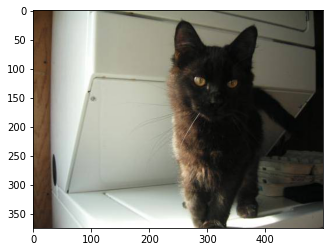

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(mpimg.imread(os.path.join(train_cats_dir, train_cat_fnames[0])))

**4) Import the VGG-16 model**

In [ ]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model.trainable = False #freeze the layers
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

**5) Add new layers and compile the model for the new dataset** 



In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


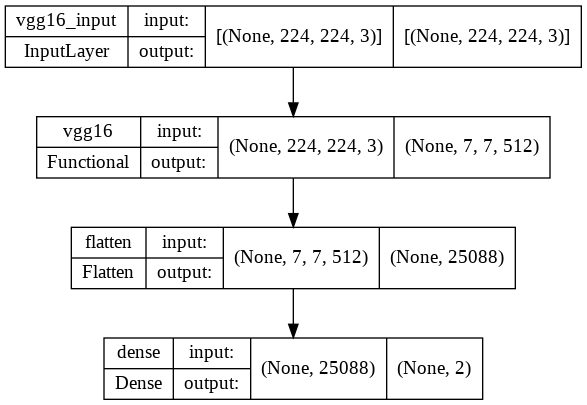

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

**6) Train the model**

In [ ]:
history = model.fit(
train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/2
100/100 [==============================] - 24s 122ms/step - loss: 0.4476 - acc: 0.7945 - val_loss: 0.3526 - val_acc: 0.8560
Epoch 2/2
100/100 [==============================] - 12s 116ms/step - loss: 0.2726 - acc: 0.9010 - val_loss: 0.2779 - val_acc: 0.8850


ALEXNET IMPLEMENTATION

In [ ]:

model_alexnet = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  # To Flatten layer
  tf.keras.layers.Flatten(),
  # To FC layer 1
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  #To FC layer 2
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
model_alexnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_104 (Ba  (None, 54, 54, 96)       384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_105 (Conv2D)         (None, 27, 27, 256)       2973952   
                                                                 
 batch_normalization_105 (Ba  (None, 27, 27, 256)      1024      
 tchNormalization)                                               
                                                      

In [ ]:
model_alexnet.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

In [ ]:
history = model_alexnet.fit(
train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/30
100/100 [==============================] - 11s 113ms/step - loss: 0.1206 - acc: 0.9555 - val_loss: 1.2137 - val_acc: 0.6250
Epoch 2/30
100/100 [==============================] - 11s 112ms/step - loss: 0.1117 - acc: 0.9565 - val_loss: 1.1354 - val_acc: 0.6440
Epoch 3/30
100/100 [==============================] - 12s 115ms/step - loss: 0.0726 - acc: 0.9730 - val_loss: 1.2299 - val_acc: 0.6490
Epoch 4/30
100/100 [==============================] - 11s 112ms/step - loss: 0.0338 - acc: 0.9900 - val_loss: 1.3462 - val_acc: 0.6720
Epoch 5/30
100/100 [==============================] - 11s 111ms/step - loss: 0.0331 - acc: 0.9910 - val_loss: 1.1794 - val_acc: 0.6660
Epoch 6/30
100/100 [==============================] - 11s 110ms/step - loss: 0.0278 - acc: 0.9915 - val_loss: 1.5494 - val_acc: 0.6500
Epoch 7/30
100/100 [==============================] - 11s 111ms/step - loss: 0.0791 - acc: 0.9665 - val_loss: 1.4824 - val_acc: 0.6400
Epoch 8/30
100/100 [==============================] - 1

In [ ]:
model_alexnet.evaluate(validation_generator) # In the above epochs we can clearly see that the model is overfitting.

50/50 [==============================] - 3s 66ms/step - loss: 1.7262 - acc: 0.6500


[1.7261502742767334, 0.6499999761581421]

GOOGLENET PRETRAINED

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
model_inceptionv3 = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
model_inceptionv3.trainable = False #freeze the layers
model_inceptionv3.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 111, 111, 32  96         ['conv2d_10[0][0]']              
 ormalization)        

In [ ]:
model_1 = tf.keras.Sequential([
    model_inceptionv3,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])
model_1.summary()

model_1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_11 (Flatten)        (None, 51200)             0         
                                                                 
 dense_20 (Dense)            (None, 2)                 102402    
                                                                 
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
history = model_1.fit(
train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/10
100/100 [==============================] - 15s 119ms/step - loss: 0.0910 - acc: 0.9640 - val_loss: 0.1397 - val_acc: 0.9700
Epoch 2/10
100/100 [==============================] - 11s 106ms/step - loss: 0.0129 - acc: 0.9970 - val_loss: 0.0577 - val_acc: 0.9850
Epoch 3/10
100/100 [==============================] - 11s 107ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9800
Epoch 4/10
100/100 [==============================] - 11s 107ms/step - loss: 7.8173e-04 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9870
Epoch 5/10
100/100 [==============================] - 13s 129ms/step - loss: 5.0348e-04 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9870
Epoch 6/10
100/100 [==============================] - 11s 107ms/step - loss: 3.8237e-04 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9870
Epoch 7/10
100/100 [==============================] - 11s 107ms/step - loss: 3.1630e-04 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9870
Epoch 8/10
100/100 [===================

In [ ]:
model_1.evaluate(validation_generator) # By using Inception V3 pretrained weights usig transfer learning our model is performing really well with a very high accuracy.

50/50 [==============================] - 4s 73ms/step - loss: 0.0537 - acc: 0.9880


[0.05374730005860329, 0.9879999756813049]

Resnet 50

In [ ]:
from keras.applications.resnet import ResNet50

In [ ]:
model_resnet = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model_resnet.trainable = False #freeze the layers
model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model_2 = tf.keras.Sequential([
    model_resnet,
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model_2.summary()

model_2.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_12 (Flatten)        (None, 100352)            0         
                                                                 
 dense_21 (Dense)            (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
history = model_2.fit(
train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/10
100/100 [==============================] - 22s 166ms/step - loss: 0.6870 - acc: 0.5900 - val_loss: 0.6348 - val_acc: 0.6300
Epoch 2/10
100/100 [==============================] - 11s 112ms/step - loss: 0.6447 - acc: 0.6335 - val_loss: 0.6349 - val_acc: 0.6370
Epoch 3/10
100/100 [==============================] - 12s 124ms/step - loss: 0.6330 - acc: 0.6375 - val_loss: 0.8657 - val_acc: 0.5380
Epoch 4/10
100/100 [==============================] - 11s 110ms/step - loss: 0.6200 - acc: 0.6500 - val_loss: 0.6285 - val_acc: 0.6500
Epoch 5/10
100/100 [==============================] - 11s 111ms/step - loss: 0.6226 - acc: 0.6540 - val_loss: 0.6395 - val_acc: 0.6450
Epoch 6/10
100/100 [==============================] - 11s 110ms/step - loss: 0.5846 - acc: 0.6795 - val_loss: 0.5992 - val_acc: 0.6820
Epoch 7/10
100/100 [==============================] - 11s 110ms/step - loss: 0.5779 - acc: 0.6835 - val_loss: 0.6082 - val_acc: 0.6740
Epoch 8/10
100/100 [==============================] - 1

In [ ]:
model_2.evaluate(validation_generator)

50/50 [==============================] - 4s 75ms/step - loss: 0.6178 - acc: 0.6610


[0.6178069710731506, 0.6610000133514404]

EfficientNetB0

In [ ]:
from keras.applications.efficientnet import EfficientNetB0

In [ ]:
model_efficientnet = EfficientNetB0(input_shape=(224,224,3), weights='imagenet', include_top=False)
model_efficientnet.trainable = False #freeze the layers
model_efficientnet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
model_3 = tf.keras.Sequential([
    model_efficientnet,
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model_3.summary()

model_3.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_13 (Flatten)        (None, 62720)             0         
                                                                 
 dense_22 (Dense)            (None, 2)                 125442    
                                                                 
Total params: 4,175,013
Trainable params: 125,442
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
history = model_3.fit(
train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/20
100/100 [==============================] - 17s 117ms/step - loss: 0.8274 - acc: 0.5020 - val_loss: 0.7425 - val_acc: 0.5000
Epoch 2/20
100/100 [==============================] - 12s 118ms/step - loss: 0.7648 - acc: 0.4965 - val_loss: 0.7255 - val_acc: 0.5000
Epoch 3/20
100/100 [==============================] - 10s 103ms/step - loss: 0.7211 - acc: 0.5200 - val_loss: 0.7752 - val_acc: 0.5000
Epoch 4/20
100/100 [==============================] - 10s 103ms/step - loss: 0.7648 - acc: 0.4920 - val_loss: 0.7878 - val_acc: 0.5000
Epoch 5/20
100/100 [==============================] - 10s 103ms/step - loss: 0.7360 - acc: 0.5180 - val_loss: 0.7086 - val_acc: 0.5000
Epoch 6/20
100/100 [==============================] - 10s 103ms/step - loss: 0.7211 - acc: 0.5085 - val_loss: 0.7480 - val_acc: 0.5000
Epoch 7/20
100/100 [==============================] - 10s 104ms/step - loss: 0.7501 - acc: 0.5175 - val_loss: 0.8226 - val_acc: 0.5000
Epoch 8/20
100/100 [==============================] - 1

In [ ]:
model_3.evaluate(validation_generator)

50/50 [==============================] - 4s 70ms/step - loss: 0.7875 - acc: 0.5000


[0.787508487701416, 0.5]

MobileNet V2

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
model_mobilenet = MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
model_mobilenet.trainable = False #freeze the layers
model_mobilenet.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
model_4 = tf.keras.Sequential([
    model_mobilenet,
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model_4.summary()

model_4.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_14 (Flatten)        (None, 62720)             0         
                                                                 
 dense_23 (Dense)            (None, 2)                 125442    
                                                                 
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history = model_4.fit(
train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/20
100/100 [==============================] - 15s 127ms/step - loss: 0.1421 - acc: 0.9500 - val_loss: 0.0982 - val_acc: 0.9750
Epoch 2/20
100/100 [==============================] - 10s 98ms/step - loss: 0.0105 - acc: 0.9975 - val_loss: 0.0822 - val_acc: 0.9760
Epoch 3/20
100/100 [==============================] - 10s 99ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0822 - val_acc: 0.9770
Epoch 4/20
100/100 [==============================] - 10s 98ms/step - loss: 7.3862e-04 - acc: 1.0000 - val_loss: 0.0776 - val_acc: 0.9780
Epoch 5/20
100/100 [==============================] - 10s 97ms/step - loss: 4.9944e-04 - acc: 1.0000 - val_loss: 0.0780 - val_acc: 0.9770
Epoch 6/20
100/100 [==============================] - 10s 98ms/step - loss: 3.9774e-04 - acc: 1.0000 - val_loss: 0.0779 - val_acc: 0.9770
Epoch 7/20
100/100 [==============================] - 10s 97ms/step - loss: 3.3461e-04 - acc: 1.0000 - val_loss: 0.0779 - val_acc: 0.9770
Epoch 8/20
100/100 [=========================

In [ ]:
model_4.evaluate(validation_generator)

50/50 [==============================] - 3s 67ms/step - loss: 0.0796 - acc: 0.9800


[0.07959751039743423, 0.9800000190734863]